In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import numpy as np


Reading data

In [133]:
messages = pandas.read_csv('/home/saurabh/Downloads/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])

<h4>Examining Data we have</h4>

In [134]:
print messages.head()

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [135]:
print "Shape = " , messages.shape, "\n"
print "Class Distribution = \n", messages.label.value_counts()

Shape =  (5574, 2) 

Class Distribution = 
ham     4827
spam     747
Name: label, dtype: int64


<h4>Preprocessing starts<h4>

In [136]:
#adding a column of length
messages['length'] = messages['message'].map(lambda text: len(text))

Using regular expressions to treat all numbers as the same
This will vastly deecrease the dictionary size and since most numbers are unique they dont help us much in learning features

In [137]:
import re

In [227]:
replace_with = " numbrrr "
#print 
for i in range(5574):
    messages.loc[i,'message'] = re.sub(r'\d+'," numbrr ",  " "+messages['message'][i]+" ")
    #print message_i


Defining functions to split the sentence
 1. Split into tokens
 2. Split into lemmas which changes words into lemmas after splitting into tokens

In [147]:
from textblob import TextBlob

In [148]:
# 1. 
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

In [149]:
# 2.
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [150]:
X = messages.message
y = messages.label
print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.series.Series'> (5574,)
<class 'pandas.core.series.Series'> (5574,)


In [151]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print X_train.shape
print y_train.shape

(4459,)
(4459,)


Vectorising our sentences by making a vocabulary of words using
1. split into lemmas as analyser
2. stop words = english (inbuilt)

In [152]:
#import
from sklearn.feature_extraction.text import CountVectorizer
#instantiate
bow_vectorizer = CountVectorizer(analyzer=split_into_lemmas, stop_words='english')
print bow_vectorizer
#fit
bow_vectorizer.fit(X_train)
#transform
messages_bow = bow_vectorizer.transform(X_train)

CountVectorizer(analyzer=<function split_into_lemmas at 0x7f643489e6e0>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=None)


SAVING VOCAB

In [153]:
vocab=bow_vectorizer.vocabulary_
print type(vocab)
import json
with open('VocabDictionary.txt', 'w') as outfile:   
    json.dump(vocab, outfile)
#import json2html
#data=json.loads('Failed.txt')
#print json2html.convert(json = vocab)
    
#import cPickle as pickle
#with open('data.p', 'wb') as fp:          //.p FORMAT
    #pickle.dump(vocab, fp)

<type 'dict'>


In [154]:
print type(messages_bow)
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

<class 'scipy.sparse.csr.csr_matrix'>
sparse matrix shape: (4459, 7043)
number of non-zeros: 64031
sparsity: 0.20%


Using stop words has decremented our vocabulary by a 1000 words
from 8874 to 7793

<br>
Now using <b>TF-IDF</b> to transform our bag of words matrix

In [155]:
#import
from sklearn.feature_extraction.text import TfidfTransformer
#instantiate
tfidf_transformer = TfidfTransformer()
#fit and transform
messages_tfidf_X_train = tfidf_transformer.fit_transform(messages_bow)

In [156]:
from scipy import sparse, io
io.mmwrite("test.mtx", messages_tfidf_X_train)

<h4> Training our model </h4>

<h6>1. Logistic Regression</h6>

In [157]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
%time params_logreg = logreg.fit(messages_tfidf_X_train, y_train)
print type(params_logreg)
print logreg.coef_.size

CPU times: user 28 ms, sys: 8 ms, total: 36 ms
Wall time: 24.2 ms
<class 'sklearn.linear_model.logistic.LogisticRegression'>
7043


<h6>2. Naive Bayes<h6>

In [158]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
%time params_nb = nb.fit(messages_tfidf_X_train, y_train)
print type(params_nb)
print nb.coef_.size

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 13.5 ms
<class 'sklearn.naive_bayes.MultinomialNB'>
7043


# <h6>3. K neighbors<h6>

In [159]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2,algorithm="brute")
neigh.fit(messages_tfidf_X_train,y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

<h6>4. Support Vector Machine<h6>

In [179]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(y_train, n_folds=5),  # what type of cross validation to use
)

In [180]:
%time svm_detector = grid_svm.fit(X_train, y_train) # find the best combination from param_svm
print svm_detector.grid_scores_

CPU times: user 4.48 s, sys: 188 ms, total: 4.66 s
Wall time: 1min 39s
[mean: 0.98677, std: 0.00370, params: {'classifier__kernel': 'linear', 'classifier__C': 1}, mean: 0.98744, std: 0.00409, params: {'classifier__kernel': 'linear', 'classifier__C': 10}, mean: 0.98722, std: 0.00330, params: {'classifier__kernel': 'linear', 'classifier__C': 100}, mean: 0.98722, std: 0.00330, params: {'classifier__kernel': 'linear', 'classifier__C': 1000}, mean: 0.86611, std: 0.00040, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.86611, std: 0.00040, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.91904, std: 0.00554, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.86611, std: 0.00040, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.97690, std: 0.00378, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'r

In [181]:
from sklearn import svm
svm_linear = svm.SVC(kernel='linear', C=100)

In [182]:
%time params_svm = svm_linear.fit(messages_tfidf_X_train, y_train)
print type(params_svm)
print svm_linear.coef_.size

CPU times: user 584 ms, sys: 0 ns, total: 584 ms
Wall time: 583 ms
<class 'sklearn.svm.classes.SVC'>
2794


In [183]:
from sklearn.svm import LinearSVC
svm_linearsvc = LinearSVC(C=10)

In [184]:
%time params_svm_ls = svm_linearsvc.fit(messages_tfidf_X_train, y_train)
print type(params_svm_ls)
print svm_linearsvc.coef_.size

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 59.5 ms
<class 'sklearn.svm.classes.LinearSVC'>
7043




<h4>Testing the models<h4>

In [185]:
#converting X_test to suitable form for input
X_test_tfidf = tfidf_transformer.transform(bow_vectorizer.transform(X_test))

In [186]:
y_pred_logreg = logreg.predict(X_test_tfidf)

In [187]:
y_pred_nb = nb.predict(X_test_tfidf)

In [188]:
y_pred_km=neigh.predict(X_test_tfidf)

In [189]:
y_pred_svm_linear = svm_linear.predict(X_test_tfidf)

In [190]:
y_pred_svm_linearsvc = svm_linearsvc.predict(X_test_tfidf)

In [191]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

TODO: Using second method (manual one) to transform testing set

In [192]:
#Logistic Regression Accuracy
print accuracy_score(y_test, y_pred_logreg)

0.975784753363


In [193]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_logreg)
print '(row=expected, col=predicted)'

confusion matrix
[[963   2]
 [ 25 125]]
(row=expected, col=predicted)


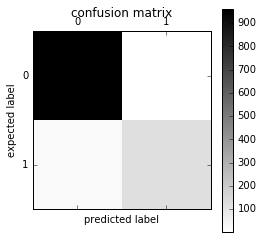

In [194]:
plt.matshow(confusion_matrix(y_test, y_pred_logreg), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [195]:
print classification_report(y_test, y_pred_logreg)

             precision    recall  f1-score   support

        ham       0.97      1.00      0.99       965
       spam       0.98      0.83      0.90       150

avg / total       0.98      0.98      0.97      1115



In [196]:
#Naive Bayes Accuracy
print accuracy_score(y_test, y_pred_nb)

0.958744394619


In [197]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_nb)
print '(row=expected, col=predicted)'

confusion matrix
[[965   0]
 [ 46 104]]
(row=expected, col=predicted)


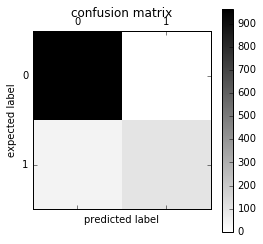

In [198]:
plt.matshow(confusion_matrix(y_test, y_pred_nb), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [199]:
print classification_report(y_test, y_pred_nb)

             precision    recall  f1-score   support

        ham       0.95      1.00      0.98       965
       spam       1.00      0.69      0.82       150

avg / total       0.96      0.96      0.96      1115



In [200]:
#K neighbors Accuracy
print accuracy_score(y_test, y_pred_km)

0.934529147982


In [201]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_nb)
print '(row=expected, col=predicted)'

confusion matrix
[[965   0]
 [ 46 104]]
(row=expected, col=predicted)


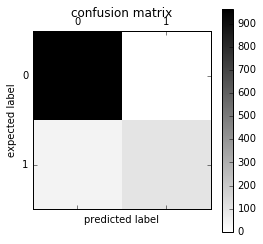

In [202]:
plt.matshow(confusion_matrix(y_test, y_pred_nb), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [203]:
print classification_report(y_test, y_pred_nb)

             precision    recall  f1-score   support

        ham       0.95      1.00      0.98       965
       spam       1.00      0.69      0.82       150

avg / total       0.96      0.96      0.96      1115



In [204]:
#SVM Accuracy
y_pred_svm = svm_detector.predict(X_test)
print accuracy_score(y_test, y_pred_svm)
print confusion_matrix(y_test, y_pred_svm)
print classification_report(y_test, y_pred_svm)

0.987443946188
[[964   1]
 [ 13 137]]
             precision    recall  f1-score   support

        ham       0.99      1.00      0.99       965
       spam       0.99      0.91      0.95       150

avg / total       0.99      0.99      0.99      1115



In [205]:
#SVM Accuracy
print accuracy_score(y_test, y_pred_svm_linear)
print confusion_matrix(y_test, y_pred_svm_linear)
print classification_report(y_test, y_pred_svm_linear)

0.984753363229
[[962   3]
 [ 14 136]]
             precision    recall  f1-score   support

        ham       0.99      1.00      0.99       965
       spam       0.98      0.91      0.94       150

avg / total       0.98      0.98      0.98      1115



In [206]:
#SVM Accuracy
print accuracy_score(y_test, y_pred_svm_linearsvc)
print confusion_matrix(y_test, y_pred_svm_linearsvc)
print classification_report(y_test, y_pred_svm_linearsvc)

0.988340807175
[[964   1]
 [ 12 138]]
             precision    recall  f1-score   support

        ham       0.99      1.00      0.99       965
       spam       0.99      0.92      0.96       150

avg / total       0.99      0.99      0.99      1115



<h6>Using Pipeline and GridSearchCV<h6>

In [207]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [208]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(y_train, n_folds=5),  # what type of cross validation to use
)

In [209]:
nb_detector = grid.fit(X_train, y_train)

In [210]:
print nb_detector.grid_scores_

[mean: 0.95874, std: 0.00548, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_lemmas at 0x7f643489e6e0>}, mean: 0.93474, std: 0.00633, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_lemmas at 0x7f643489e6e0>}, mean: 0.95874, std: 0.00540, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_tokens at 0x7f64344c9320>}, mean: 0.93519, std: 0.00465, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_tokens at 0x7f64344c9320>}]


In [211]:
y_pred_nb_grid = nb_detector.predict(X_test)

In [212]:
print accuracy_score(y_test, y_pred_nb_grid)

0.958744394619


In [213]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_nb_grid)
print '(row=expected, col=predicted)'

confusion matrix
[[965   0]
 [ 46 104]]
(row=expected, col=predicted)


In [214]:
print classification_report(y_test, y_pred_nb_grid)

             precision    recall  f1-score   support

        ham       0.95      1.00      0.98       965
       spam       1.00      0.69      0.82       150

avg / total       0.96      0.96      0.96      1115




Results improved!

In [215]:
print nb_detector.predict(["Hi mom, how are you?"])[0]

ham


<h3>Comparing Models</h3>

LR: 0.973085 (0.007040)
NB: 0.961870 (0.011805)
SVM: 0.866107 (0.017571)


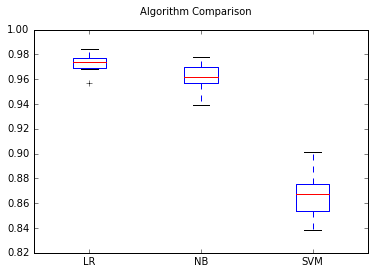

In [216]:
from sklearn import cross_validation
# prepare configuration for cross validation test harness
num_folds = 10
num_instances = len(X_train)
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', MultinomialNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, messages_tfidf_X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [217]:
bow_vectorizer2 = CountVectorizer(analyzer=split_into_lemmas, stop_words='english')
print bow_vectorizer2
#fit
bow_vectorizer2.fit(X)
#transform
messages_bow2 = bow_vectorizer2.transform(X)

CountVectorizer(analyzer=<function split_into_lemmas at 0x7f643489e6e0>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=None)


In [218]:
print messages_bow.shape
print messages_bow2.shape
print X.shape

(4459, 7043)
(5574, 7829)
(5574,)


In [219]:
tfidf_transformer2 = TfidfTransformer()
#fit and transform
messages_tfidf_X = tfidf_transformer2.fit_transform(messages_bow2)
print messages_tfidf_X.shape
print messages_tfidf_X_train.shape

(5574, 7829)
(4459, 7043)


In [220]:
from sklearn.svm import LinearSVC
svm2 = LinearSVC(C=10)
%time params_svm2 = svm2.fit(messages_tfidf_X, y)
print type(params_svm2)
print svm2.coef_.size

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 72.8 ms
<class 'sklearn.svm.classes.LinearSVC'>
7829


In [221]:
#sanity check
x1 = bow_vectorizer2.transform(["Free entry in 2 a wkly comp to win FA Cup " ,"Urgent! Free discount sale buy at low prices", "Hello there!"])
x2 = tfidf_transformer2.transform(x1)
print x1.shape
print x2.shape
svm2.predict(x2)

(3, 7829)
(3, 7829)


array(['ham', 'ham', 'ham'], dtype=object)

In [222]:
svm2.intercept_

array([-1.32407398])

from sklearn.metrics import roc_curve, auc

In [223]:
vocab2=bow_vectorizer2.vocabulary_
print type(vocab2)
import json
with open('VocabDictionary2.json', 'w') as outfile:   
    json.dump(vocab2, outfile, separators=(',', ':'))

<type 'dict'>


In [224]:
type(svm2.coef_)
coef = svm2.coef_.tolist();
with open('Coefficients_svm.json', 'w') as outfile:   
    json.dump(coef, outfile)
#np.savetxt('Coefficients_svm.txt', svm2.coef_, delimiter=',')
#with open('Coefficients_svm.txt', 'w') as outfile:   
#    json.dump(svm2.coef_, outfile)

In [225]:
print 

In [226]:
idf = tfidf_transformer2.idf_.tolist()
with open('idf.json', 'w') as outfile:   
    json.dump(idf, outfile)